In [68]:
import torch
from torchvision import transforms
import glob
import re
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image
import PIL
import pickle
import matplotlib.pyplot as plt
from dataReader import DataReader
from torch.utils.data import DataLoader

## Preprocess

In [160]:
nums = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
lower_char = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
              'v', 'w', 'x', 'y', 'z']
upper_char = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
              'V', 'W', 'X', 'Y', 'Z']

total = nums + lower_char + upper_char
classes = {}
for i in range(len(total)):
    classes[str(total[i])] = i

In [161]:
def numerize_labels(labels):
    return [classes[x] for x in labels]

In [162]:
PATH = 'captcha_images/char/'
train_path = PATH + 'train/'
test_path = PATH + 'test/'


train_files = glob.glob(train_path+"*.jpg")
test_files = glob.glob(test_path+"*.jpg")

In [163]:
def generate_labels(files_list, patten):
    return [re.sub(patten,"",x)[0] for x in files_list]

In [164]:
def generate_img(files_list):
    images = []
    for x in files_list:
        images.append(plt.imread(x)/255)
        plt.close()
    return images

In [165]:
transform = transforms.Compose([transforms.ToTensor()])
train_labels = numerize_labels(generate_labels(train_files, train_path))
train_labels = np.array(train_labels)
train = DataReader(train_path, train_labels,transform)

test_labels = numerize_labels(generate_labels(test_files, test_path))
test_labels = np.array(test_labels)
test = DataReader(test_path, test_labels, transform)

In [166]:
trainset = DataLoader(train,batch_size=32)
testset = DataLoader(test,batch_size=32)

In [167]:
for batch in trainset:
    features, labels = batch
    break
_iter = iter(range(32)) 

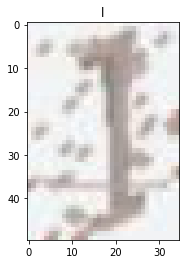

In [173]:
index = next(_iter)
plt.title(total[labels[index]])
plt.imshow(features[index].permute(1,2,0))
plt.show()

## Train

In [148]:
class Classification_Net(torch.nn.Module):
    def __init__(self):
        super(Classification_Net, self).__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(3,12,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(12,48,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(48,96,1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(96)
        )
        self.dense = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1440,1440),
            torch.nn.ReLU(),
            torch.nn.Linear(1440,720),
            torch.nn.BatchNorm1d(720),
            torch.nn.Linear(720, 360),
            torch.nn.ELU(),
            torch.nn.Linear(360,120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 62),
            torch.nn.ReLU(),
        )
        
    def forward(self, inputs):
        o = self.conv(inputs)
        o = self.dense(o)
        return o
net = Classification_Net().cuda()
hist = []
acc_hist = []

In [150]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
MODEL_PATH = "char_classification.pth"
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [147]:
def evaluate():
    total = 0.
    correct = 0.
    for batch in testset:
        features, labels = batch
        out = net(features.cuda())
        for i,x in enumerate(out):
            if torch.argmax(x) == labels[i]:
                correct += 1
        total += len(labels)
    acc = correct/total
    acc_hist.append(acc)
    return acc
#     print(f"Total -> {total}")
#     print(f"Correct -> {correct}")
#     print("Accuracy -> [%.5f]"%acc)
#     plt.title("Accuracy -> [%.5f]"%acc)
#     plt.plot(acc_hist)
#     plt.show()

EPOCH: 1/1  1875/1875 [AVG Loss -> 1.32042]

No handles with labels found to put in legend.


	Evaluation Accuracy -> 0.64817


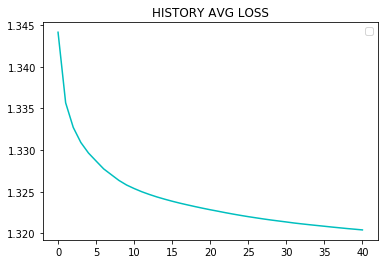

No handles with labels found to put in legend.


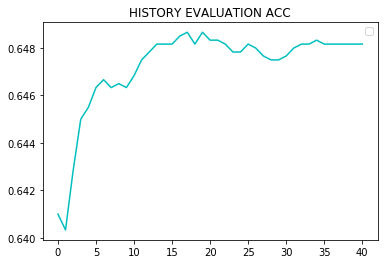

In [158]:
EPOCHS = 1
def fit(hist):
    for e in range(EPOCHS):
        running_loss = 0.
        for i, batch in enumerate(trainset):
            features, labels = batch
            out = net(features.cuda())
            loss = criterion(out, labels.cuda())
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            print(f"\rEPOCH: {e+1}/{EPOCHS}  {i+1}/{len(trainset)} [AVG Loss -> %.5f]"%(running_loss/(i+1)),end="")
            sys.stdout.flush()
        hist.append(running_loss/len(trainset))
        eval_acc = evaluate()
        print("\tEvaluation Accuracy -> %.5f"%eval_acc)
fit(hist)
plt.title('HISTORY AVG LOSS')
plt.plot(hist,'b')
plt.show()
plt.title('HISTORY EVALUATION ACC')
plt.plot(acc_hist,'c')
plt.show()

In [159]:
# torch.save(net.state_dict(),MODEL_PATH)